In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import cv2
import os

In [ ]:
/content/drive/MyDrive/Karate_2/cam1.mp4

In [ ]:
# Список видео
video_1 = '/content/drive/MyDrive/Karate_2/cam1.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/cam2.mp4'
video_list = [video_1, video_2]

# Время начала и конца в секундах для каждого видео
time_intervals = {
    'cam1.mp4': (30, 120),
    'cam2.mp4': (115, 202)
}

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 18.0 MB/s eta 0:00:00


In [ ]:
#@title Извлечение координат поз
import cv2
import mediapipe as mp
import pandas as pd
from pathlib import Path
from tqdm import tqdm  # Добавляем tqdm для отображения прогресса

# Инициализация Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Список видео и временные интервалы
video_1 = '/content/drive/MyDrive/Karate_2/cam1.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/cam2.mp4'
video_list = [video_1, video_2]

time_intervals = {
    'cam1.mp4': (30, 120),
    'cam2.mp4': (115, 202)
}

# Функция для обработки видео и сохранения данных в датафрейм
def process_video(video_path, start_time, end_time):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Получаем частоту кадров
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0
    data = []

    # Определяем границы кадров для временного интервала
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    # Создаем прогресс-бар с tqdm
    with tqdm(total=end_frame - start_frame + 1, desc=f"Processing {Path(video_path).name}") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Пропускаем кадры до начала временного интервала
            if frame_count < start_frame:
                frame_count += 1
                continue

            # Останавливаемся после конца временного интервала
            if frame_count > end_frame:
                break

            # Конвертируем кадр в RGB для Mediapipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Обрабатываем кадр с помощью Mediapipe Pose
            results = pose.process(rgb_frame)

            # Если поза найдена, извлекаем координаты и вероятности
            row_data = {'frame_number': frame_count}
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                for i, landmark in enumerate(landmarks):
                    row_data[f'x_{i}'] = landmark.x
                    row_data[f'y_{i}'] = landmark.y
                    row_data[f'z_{i}'] = landmark.z
                    row_data[f'visibility_{i}'] = landmark.visibility
            else:
                # Если поза не найдена, записываем None для всех точек
                for i in range(33):  # Mediapipe Pose имеет 33 ключевых точки
                    row_data[f'x_{i}'] = None
                    row_data[f'y_{i}'] = None
                    row_data[f'z_{i}'] = None
                    row_data[f'visibility_{i}'] = None

            data.append(row_data)
            frame_count += 1
            pbar.update(1)  # Обновляем прогресс-бар

    cap.release()
    return pd.DataFrame(data)

# Обработка всех видео
dataframes = {}
for video_path in video_list:
    video_name = Path(video_path).name
    start_time, end_time = time_intervals[video_name]
    df = process_video(video_path, start_time, end_time)
    dataframes[video_name] = df

# Сохранение датафреймов в CSV файлы
output_dir = '/content/drive/MyDrive/Karate_2/output'
Path(output_dir).mkdir(parents=True, exist_ok=True)

for video_name, df in dataframes.items():
    output_path = Path(output_dir) / f'{video_name}_pose_data.csv'
    df.to_csv(output_path, index=False)
    print(f"Data for {video_name} saved to {output_path}")

Processing cam2.mp4: 100%|██████████| 2619/2619 [03:04<00:00, 14.18it/s]


Data for cam1.mp4 saved to /content/drive/MyDrive/Karate_2/output/cam1.mp4_pose_data.csv
Data for cam2.mp4 saved to /content/drive/MyDrive/Karate_2/output/cam2.mp4_pose_data.csv


Видео cam2 опережает cam1 на 46 кадров.


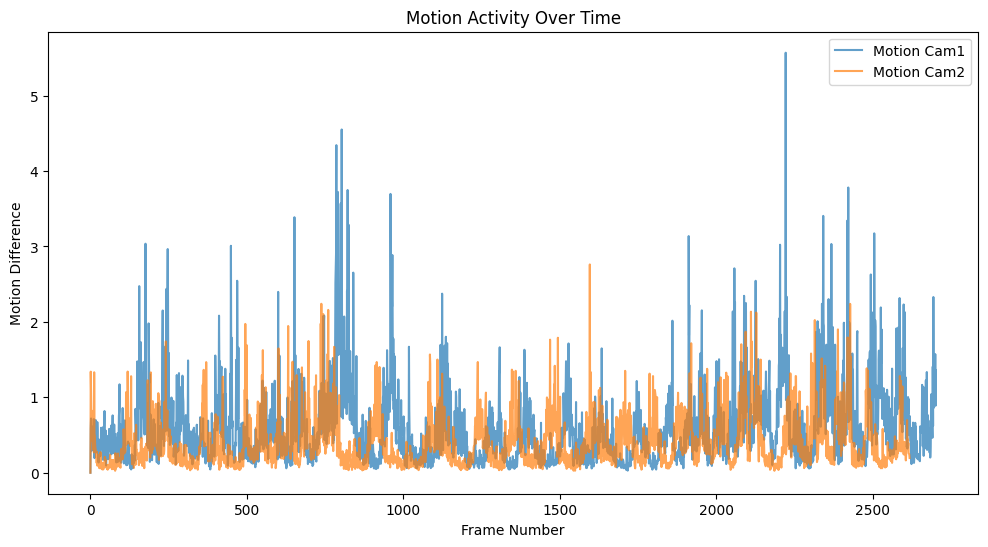

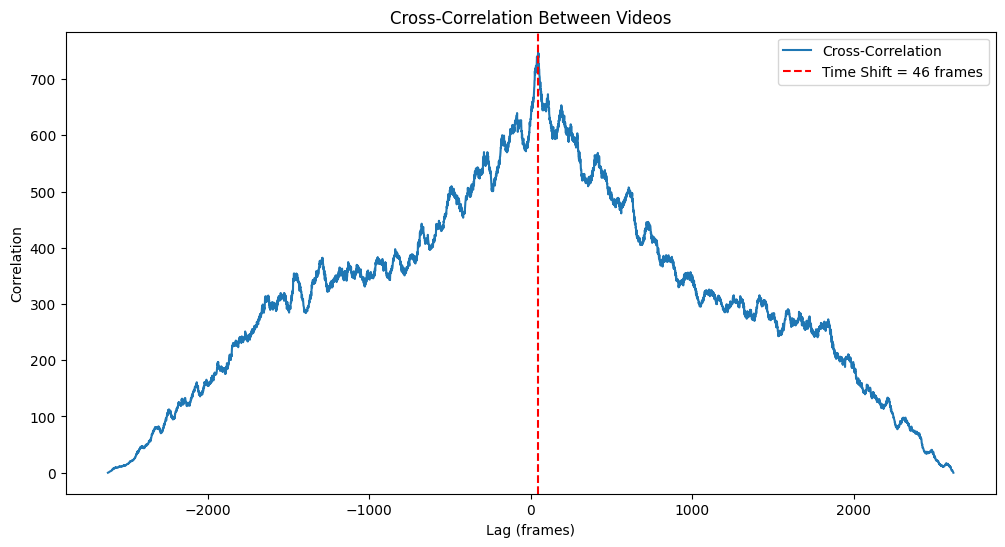

In [ ]:
#@title  Анализ частоты движения и определения сдвига видео относительно друг друга
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Функция для вычисления изменений координат
def compute_motion_differences(df):
    motion_diffs = []
    for i in range(33):  # 33 ключевых точки Mediapipe Pose
        x_col = f'x_{i}'
        y_col = f'y_{i}'
        z_col = f'z_{i}'

        # Вычисляем разницу между последовательными кадрами
        dx = df[x_col].diff().fillna(0)
        dy = df[y_col].diff().fillna(0)
        dz = df[z_col].diff().fillna(0)

        # Суммарное изменение координат
        motion_diff = np.sqrt(dx**2 + dy**2 + dz**2)
        motion_diffs.append(motion_diff)

    # Общая активность движения как сумма по всем точкам
    total_motion = sum(motion_diffs)
    return total_motion

# Функция для нахождения временного сдвига
def find_time_shift(motion_1, motion_2):
    # Обрезаем более длинный ряд до длины более короткого
    min_length = min(len(motion_1), len(motion_2))
    motion_1 = motion_1[:min_length]
    motion_2 = motion_2[:min_length]

    # Вычисляем перекрестную корреляцию
    correlation = correlate(motion_1, motion_2, mode='full')
    lags = np.arange(-len(motion_1) + 1, len(motion_1))

    # Находим лаг с максимальной корреляцией
    max_corr_index = np.argmax(correlation)
    time_shift = lags[max_corr_index]
    return time_shift, correlation, lags

# Загрузка данных из CSV
output_dir = '/content/drive/MyDrive/Karate_2/output'
df_cam1 = pd.read_csv(f'{output_dir}/cam1.mp4_pose_data.csv')
df_cam2 = pd.read_csv(f'{output_dir}/cam2.mp4_pose_data.csv')

# Вычисление изменений координат
motion_cam1 = compute_motion_differences(df_cam1)
motion_cam2 = compute_motion_differences(df_cam2)

# Нахождение временного сдвига
time_shift, correlation, lags = find_time_shift(motion_cam1, motion_cam2)

# Интерпретация результата
if time_shift > 0:
    print(f"Видео cam2 опережает cam1 на {time_shift} кадров.")
elif time_shift < 0:
    print(f"Видео cam1 опережает cam2 на {-time_shift} кадров.")
else:
    print("Видео синхронизированы (временной сдвиг равен 0).")

# Визуализация частоты движения
plt.figure(figsize=(12, 6))
plt.plot(motion_cam1, label='Motion Cam1', alpha=0.7)
plt.plot(motion_cam2, label='Motion Cam2', alpha=0.7)
plt.title('Motion Activity Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Motion Difference')
plt.legend()
plt.show()

# Визуализация перекрестной корреляции
plt.figure(figsize=(12, 6))
plt.plot(lags, correlation, label='Cross-Correlation')
plt.axvline(x=time_shift, color='red', linestyle='--', label=f'Time Shift = {time_shift} frames')
plt.title('Cross-Correlation Between Videos')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()
plt.show()

Видео cam2 опережает cam1 на 58 кадров.


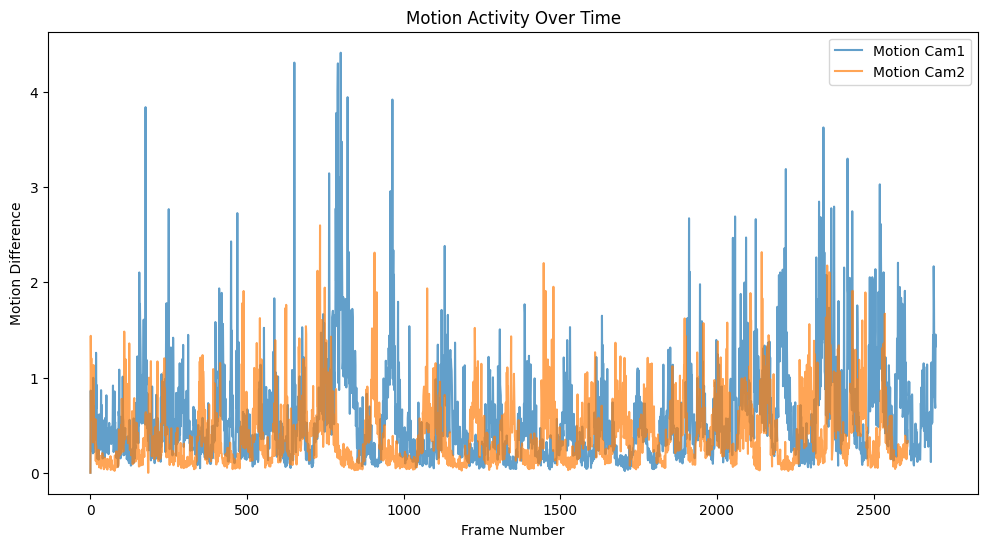

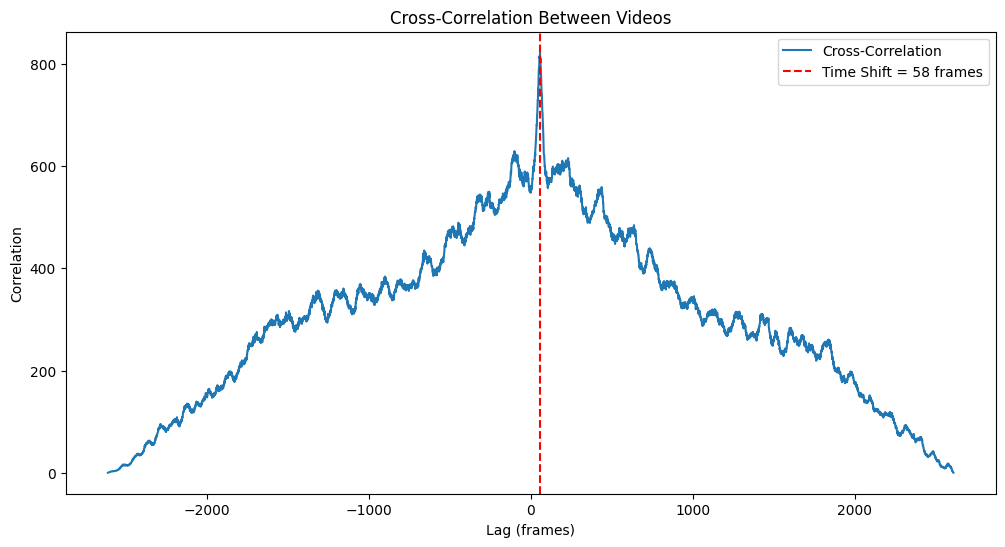

In [ ]:
#@title  Анализ частоты движения и определения сдвига видео относительно друг друга
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Функция для вычисления изменений координат
def compute_motion_differences(df):
    motion_diffs = []
    for i in range(33):  # 33 ключевых точки Mediapipe Pose
        x_col = f'x_{i}'
        y_col = f'y_{i}'
        z_col = f'z_{i}'

        # Вычисляем разницу между последовательными кадрами
        dx = df[x_col].diff().fillna(0)
        dy = df[y_col].diff().fillna(0)
        dz = df[z_col].diff().fillna(0)

        # Суммарное изменение координат
        motion_diff = np.sqrt(dx**2 + dy**2 + dz**2)
        motion_diffs.append(motion_diff)

    # Общая активность движения как сумма по всем точкам
    total_motion = sum(motion_diffs)
    return total_motion

# Функция для нахождения временного сдвига
def find_time_shift(motion_1, motion_2):
    # Обрезаем более длинный ряд до длины более короткого
    min_length = min(len(motion_1), len(motion_2))
    motion_1 = motion_1[:min_length]
    motion_2 = motion_2[:min_length]

    # Вычисляем перекрестную корреляцию
    correlation = correlate(motion_1, motion_2, mode='full')
    lags = np.arange(-len(motion_1) + 1, len(motion_1))

    # Находим лаг с максимальной корреляцией
    max_corr_index = np.argmax(correlation)
    time_shift = lags[max_corr_index]
    return time_shift, correlation, lags

# Загрузка данных из CSV
output_dir = '/content/drive/MyDrive/Karate_2/output'
df_cam1 = pd.read_csv(f'{output_dir}/cam1.mp4_30fps_pose_data.csv')
df_cam2 = pd.read_csv(f'{output_dir}/cam2.mp4_30fps_pose_data.csv')

# Вычисление изменений координат
motion_cam1 = compute_motion_differences(df_cam1)
motion_cam2 = compute_motion_differences(df_cam2)

# Нахождение временного сдвига
time_shift, correlation, lags = find_time_shift(motion_cam1, motion_cam2)

# Интерпретация результата
if time_shift > 0:
    print(f"Видео cam2 опережает cam1 на {time_shift} кадров.")
elif time_shift < 0:
    print(f"Видео cam1 опережает cam2 на {-time_shift} кадров.")
else:
    print("Видео синхронизированы (временной сдвиг равен 0).")

# Визуализация частоты движения
plt.figure(figsize=(12, 6))
plt.plot(motion_cam1, label='Motion Cam1', alpha=0.7)
plt.plot(motion_cam2, label='Motion Cam2', alpha=0.7)
plt.title('Motion Activity Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Motion Difference')
plt.legend()
plt.show()

# Визуализация перекрестной корреляции
plt.figure(figsize=(12, 6))
plt.plot(lags, correlation, label='Cross-Correlation')
plt.axvline(x=time_shift, color='red', linestyle='--', label=f'Time Shift = {time_shift} frames')
plt.title('Cross-Correlation Between Videos')
plt.xlabel('Lag (frames)')
plt.ylabel('Correlation')
plt.legend()
plt.show()

In [ ]:
#@title Создаем комбинированное видео
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Отключаем предупреждения о frozen modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Игнорируем INFO и WARNING сообщения TensorFlow

import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Инициализация Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Параметры видео и временных интервалов
video_1 = '/content/drive/MyDrive/Karate_2/cam1.mp4'
video_2 = '/content/drive/MyDrive/Karate_2/cam2.mp4'
output_dir = '/content/drive/MyDrive/Karate_2/output'

time_intervals = {
    'cam1.mp4': (30, 120),
    'cam2.mp4': (115, 202)
}

# временной сдвиг: Видео cam2 опережает cam1 на 46 кадров.
time_shift_frames = -46

# Функция для обработки видео и записи результата в выходное видео
def process_and_write_video(video_path, start_time, end_time, time_shift, output_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Определяем границы кадров для временного интервала
    start_frame = int(start_time * fps) + time_shift
    end_frame = int(end_time * fps) + time_shift
    frame_count = 0

    # Создаем выходное видео
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    with tqdm(total=end_frame - start_frame + 1, desc=f"Processing {Path(video_path).name}") as pbar:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Пропускаем кадры до начала временного интервала
            if frame_count < start_frame:
                frame_count += 1
                continue

            # Останавливаемся после конца временного интервала
            if frame_count > end_frame:
                break

            # Конвертируем кадр в RGB для Mediapipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Обрабатываем кадр с помощью Mediapipe Pose
            results = pose.process(rgb_frame)

            # Рисуем позу на кадре
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    frame,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
                )

            # Записываем обработанный кадр в выходное видео
            out.write(frame)
            frame_count += 1
            pbar.update(1)

    cap.release()
    out.release()

# Обработка обоих видео и создание временных файлов
temp_output_cam1 = f'{output_dir}/temp2_cam1.mp4'
temp_output_cam2 = f'{output_dir}/temp2_cam2.mp4'

process_and_write_video(video_1, *time_intervals['cam1.mp4'], time_shift=0, output_path=temp_output_cam1)
process_and_write_video(video_2, *time_intervals['cam2.mp4'], time_shift=time_shift_frames, output_path=temp_output_cam2)

# Объединение видео
cap1 = cv2.VideoCapture(temp_output_cam1)
cap2 = cv2.VideoCapture(temp_output_cam2)

fps_cam1 = cap1.get(cv2.CAP_PROP_FPS)
width_cam1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
height_cam1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

fps_cam2 = cap2.get(cv2.CAP_PROP_FPS)
width_cam2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
height_cam2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_width = width_cam1 + width_cam2
output_height = max(height_cam1, height_cam2)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(f'{output_dir}/combined_video.mp4', fourcc, fps_cam1, (output_width, output_height))

while True:
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()

    if not ret1 or not ret2:
        break

    # Изменяем размеры кадров, если они различаются
    if frame1.shape[0] != output_height or frame1.shape[1] != width_cam1:
        frame1 = cv2.resize(frame1, (width_cam1, output_height))
    if frame2.shape[0] != output_height or frame2.shape[1] != width_cam2:
        frame2 = cv2.resize(frame2, (width_cam2, output_height))

    # Горизонтальное объединение кадров
    combined_frame = np.hstack((frame1, frame2))
    out.write(combined_frame)

cap1.release()
cap2.release()
out.release()

print("Combined video saved successfully!")

Processing cam2.mp4: 100%|██████████| 2619/2619 [03:23<00:00, 12.86it/s]


Combined video saved successfully!


# Получившееся видео:

https://drive.google.com/file/d/1-9Kw5hYfGfUTavYCMxI4M9pAfe7XomeU/view?usp=sharing


# Вывод точек на график

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Пути к файлам
csv_file1 = "/content/drive/MyDrive/Karate_2/output/cam1.mp4_pose_data.csv"
csv_file2 = "/content/drive/MyDrive/Karate_2/output/cam2.mp4_pose_data.csv"

# Загрузка данных
df1 = pd.read_csv(csv_file1)
df2 = pd.read_csv(csv_file2)

In [ ]:
df2

,frame_number,x_0,y_0,z_0,visibility_0,x_1,y_1,z_1,visibility_1,x_2,...,z_30,visibility_30,x_31,y_31,z_31,visibility_31,x_32,y_32,z_32,visibility_32
0,3460,0.317988,0.141998,-0.017498,0.986436,0.316964,0.130259,-0.007948,0.984592,0.317127,...,-0.020266,0.928204,0.364993,0.664380,0.140737,0.786163,0.373621,0.689600,-0.060233,0.749172
1,3461,0.315052,0.145764,0.002291,0.966405,0.311291,0.135609,0.013369,0.965259,0.310728,...,0.057002,0.891322,0.356423,0.607642,0.267482,0.719275,0.351070,0.626806,0.019933,0.723259
2,3462,0.313289,0.142365,0.025511,0.966665,0.308697,0.131141,0.036625,0.965453,0.308194,...,0.008601,0.851568,0.355321,0.630182,0.172705,0.658874,0.359356,0.649029,-0.029633,0.697503
3,3463,0.313819,0.148579,0.017855,0.966813,0.309668,0.138229,0.028946,0.966056,0.309232,...,-0.058224,0.829349,0.356652,0.628556,0.149952,0.606562,0.371564,0.646668,-0.102275,0.680055
4,3464,0.313506,0.147728,0.011078,0.968703,0.309314,0.137840,0.022062,0.967949,0.309005,...,-0.055519,0.826048,0.353929,0.606639,0.177848,0.576752,0.364182,0.629263,-0.101310,0.693669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2614,6074,0.420612,0.151773,0.053472,0.996096,0.417807,0.145393,0.047596,0.993500,0.416346,...,0.070911,0.901905,0.428959,0.476497,0.155698,0.504498,0.451922,0.478542,0.050924,0.835573
2615,6075,0.420118,0.152109,0.055217,0.995951,0.417400,0.145665,0.048481,0.993439,0.415905,...,0.076290,0.906696,0.426301,0.478950,0.122578,0.501855,0.457452,0.477019,0.059328,0.830009
2616,6076,0.420511,0.152513,0.052127,0.996077,0.417977,0.145981,0.044439,0.993756,0.416528,...,0.109570,0.909364,0.422641,0.478988,0.123803,0.501562,0.454122,0.467176,0.097264,0.815936
2617,6077,0.423616,0.152614,0.050652,0.995898,0.421583,0.146303,0.043728,0.993691,0.420353,...,0.133496,0.900971,0.419744,0.481351,0.112438,0.493546,0.453339,0.465348,0.122772,0.784818


In [ ]:
# Список пар точек для соединения (например, для скелета MediaPipe)
connections = [
    # Лицо и шея
    (0, 1), (1, 2), (2, 3), (3, 7),  # Правая рука
    (0, 4), (4, 5), (5, 6), (6, 8),  # Левая рука
    (9, 10),                          # Рот
    (11, 12),                         # Плечи
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),  # Левая нога
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22),  # Правая нога
    (11, 23), (12, 24),               # Туловище
    (23, 24),                         # Бедра
    (23, 25), (25, 27), (27, 29), (27, 31),           # Левая нога (дополнительно)
    (24, 26), (26, 28), (28, 30), (28, 32),           # Правая нога (дополнительно)
]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider  # Добавляем IntSlider

In [ ]:
def plot_frame(frame_index, offset):
    # Получаем данные для выбранного кадра по порядку
    frame_data1 = df1.iloc[frame_index]

    # Применяем сдвиг для второй камеры
    shifted_frame_index = frame_index + offset
    if shifted_frame_index < 0 or shifted_frame_index >= len(df2):
        print(f"Сдвинутый кадр {shifted_frame_index} выходит за пределы данных второй камеры.")
        return

    frame_data2 = df2.iloc[shifted_frame_index]

    # Извлечение координат x и y для всех точек
    def extract_coordinates(frame_data):
        x_coords = []
        y_coords = []
        for col in frame_data.index:
            if col.startswith("x_"):
                x_coords.append(frame_data[col])
            elif col.startswith("y_"):
                y_coords.append(frame_data[col])
        return x_coords, y_coords

    x1, y1 = extract_coordinates(frame_data1)
    x2, y2 = extract_coordinates(frame_data2)

    # Создаем фигуру с двумя подграфиками
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # График для cam1
    axes[0].scatter(x1, y1, c='blue', label='cam1')
    axes[0].set_title(f"Camera 1 - Frame Index {frame_index}")
    axes[0].invert_yaxis()  # Инвертируем ось Y для корректного отображения
    axes[0].legend()

    # График для cam2
    axes[1].scatter(x2, y2, c='red', label='cam2')
    axes[1].set_title(f"Camera 2 - Frame Index {shifted_frame_index} (Offset: {offset})")
    axes[1].invert_yaxis()  # Инвертируем ось Y для корректного отображения
    axes[1].legend()

    # Функция для рисования связей
    def draw_connections(ax, x_coords, y_coords, connections):
        for start, end in connections:
            if start < len(x_coords) and end < len(x_coords):  # Проверяем, что индексы существуют
                ax.plot([x_coords[start], x_coords[end]], [y_coords[start], y_coords[end]], c='green')

    # Добавляем связи на графики
    draw_connections(axes[0], x1, y1, connections)
    draw_connections(axes[1], x2, y2, connections)

    # Отображение графиков
    plt.tight_layout()
    plt.show()

In [ ]:
# Создаем слайдер для выбора кадра
max_frame_index = min(len(df1), len(df2)) - 1  # Максимальный индекс кадра
frame_slider = IntSlider(min=0, max=max_frame_index, step=1, value=0, description="Frame Index")

# Создаем слайдер для выбора сдвига
offset_slider = IntSlider(min=-max_frame_index, max=max_frame_index, step=1, value=0, description="Offset")

# Привязываем функцию plot_frame к слайдерам
interact(plot_frame, frame_index=frame_slider, offset=offset_slider)

interactive(children=(IntSlider(value=0, description='Frame Index', max=2618), IntSlider(value=0, description=…

<function __main__.plot_frame(frame_index, offset)>